In [3]:
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Import data

In [268]:
end = int(time.time())
days = 7
begin = end - (3600*24*days)

In [269]:
def get_arrivals(airport): 
    url = 'https://opensky-network.org/api/flights/arrival'
    params = {'airport': airport,
             'begin': begin,
             'end': end
             }
    response = requests.get(url, params = params)
    print(response)
    return response.json()

## Data of important airports and airlines

50 most important airports according to Skytrax. Pulled from https://github.com/mabrahamde.

In [520]:
airports_df = pd.read_csv('data/skytrax-airports-top100.csv')
top_50_airports = airports_df.drop('Position-2017', axis=1)[0:50]
top_20_airports = airports_df.drop('Position-2017', axis=1)[0:20]
top_10_airports = airports_df.drop('Position-2017', axis=1)[0:10]

# Get's the airline names
airlines_df = pd.read_csv('airlines.csv') \
                .rename(columns={'Unknown':'Name', 'N/A': 'carrier', r'\N.2':'Country'}) \
                [['Name', 'carrier','Country']]

## Get arrivals from the top 10 airports in the worlds

In [525]:
top_10_airports

,Position-2018,Name,IATA,ICAO
0,1,Singapore Changi,SIN,WSSS
1,2,Seoul Incheon,ICN,RKSI
2,3,Tokyo Haneda,HND,RJTT
3,4,Hong Kong,HKG,VHHH
4,5,Doha Hamad,NaN,OTBD
5,6,Munich,MUC,EDDM
6,7,Centrair Nagoya,NKM,RJNA
7,8,London Heathrow,LHR,EGLL
8,9,Zurich,ZRH,LSZH
9,10,Frankfurt,FRA,EDDF


In [530]:
def load_airports(airport_df):
    
    airport_data = {}
    for i, airport in enumerate(airport_df['ICAO']):
        name = airport_df['Name'].loc[i]
        airport_data[name] = pd.DataFrame(get_arrivals(airport))
        print(f'Loading data of airport {name} from OpenSkies.' )
        print('......................')
    print('Done!')
    return airport_data

In [599]:
## LOAD AIRPORTS
airport_data = load_airports(top_50_airports)

<Response [200]>
Loading data of airport Singapore Changi from OpenSkies.
......................
<Response [200]>
Loading data of airport Seoul Incheon from OpenSkies.
......................
<Response [200]>
Loading data of airport Tokyo Haneda from OpenSkies.
......................
<Response [200]>
Loading data of airport Hong Kong from OpenSkies.
......................
<Response [200]>
Loading data of airport Doha Hamad from OpenSkies.
......................
<Response [200]>
Loading data of airport Munich from OpenSkies.
......................
<Response [200]>
Loading data of airport Centrair Nagoya from OpenSkies.
......................
<Response [200]>
Loading data of airport London Heathrow from OpenSkies.
......................
<Response [200]>
Loading data of airport Zurich from OpenSkies.
......................
<Response [200]>
Loading data of airport Frankfurt from OpenSkies.
......................
<Response [200]>
Loading data of airport Tokyo Narita from OpenSkies.
.........

In [600]:
backup = airport_data
backup.keys()
# airport_data=backup

In [609]:
## CLEAN FOR IMPORT ERRORS

new_dict = {}
for name, airport in airport_data.items():
    if isinstance(airport, pd.DataFrame) and not airport.empty:
        new_dict[name] = airport
        print(f'Dataset of {name} is a dataframe')
    else:
        print(f'!!!! Deleted empty dataset of {name}')
airport_data = new_dict   

Dataset of Singapore Changi is a dataframe
Dataset of Seoul Incheon is a dataframe
Dataset of Tokyo Haneda is a dataframe
Dataset of Hong Kong is a dataframe
Dataset of Doha Hamad is a dataframe
Dataset of Munich is a dataframe
Dataset of Centrair Nagoya is a dataframe
Dataset of London Heathrow is a dataframe
Dataset of Zurich is a dataframe
Dataset of Frankfurt is a dataframe
Dataset of Tokyo Narita is a dataframe
Dataset of Amsterdam Schiphol is a dataframe
Dataset of Kansai is a dataframe
Dataset of Vancouver is a dataframe
Dataset of Taiwan Taoyuan is a dataframe
Dataset of Helsinki-Vantaa is a dataframe
Dataset of Vienna is a dataframe
deleted empty dataset of Shanghai Hongqiao
Dataset of Copenhagen is a dataframe
Dataset of Sydney is a dataframe
Dataset of Cape Town is a dataframe
Dataset of Brisbane is a dataframe
Dataset of Dubai is a dataframe
Dataset of Auckland is a dataframe
Dataset of Hamburg is a dataframe
deleted empty dataset of Durban
Dataset of Melbourne is a datafra

## Enriching dataset with carrier names, countries of origin, datetime, and time-bins.

For each carrier, add timebins of hours and day sections.
1. Night - 23:00 - 05:00
2. Morning - 05:00 - 11:00
3. Afternoon - 11:00 - 17:00
4. Evening - 17:00 - 23:00

In [538]:
def hourbin(hour):
    if hour in (24, 1, 2, 3, 4, 5): return 'night'
    if hour in range(6,12): return ' morning'
    if hour in range(12,18): return 'afternoon'
    if hour in range(18,24): return 'evening'

def transform_airport_data(df, name = ''):
    '''Transforms the arrivals dataframe in a more useful version by enriching
    with datetimes, callsigns, airline name etc.''' 
    
    print(f'Transforming data of airport {name}')
    df['carrier'] = df['callsign'].str[:3]
    df = df.merge(airlines_df, on="carrier")
    df['lastSeen'] = pd.to_datetime(df['lastSeen'],unit='s')
    df['firstSeen'] = pd.to_datetime(df['firstSeen'],unit='s')
    
    df['day'] = df['firstSeen'].dt.day_name()
    df['hour'] = df['firstSeen'].dt.hour
    df['daysection'] = df['hour'].map(hourbin)
    df['weekday'] = df['firstSeen'].dt.weekday < 5
    return df

In [610]:
## TRANSFORMING THE DATA FOR top 10 airports
for name, airport in airport_data.items():
    airport_data[name] = transform_airport_data(airport, name = name)

Transforming data of airport Singapore Changi
Transforming data of airport Seoul Incheon
Transforming data of airport Tokyo Haneda
Transforming data of airport Hong Kong
Transforming data of airport Doha Hamad
Transforming data of airport Munich
Transforming data of airport Centrair Nagoya
Transforming data of airport London Heathrow
Transforming data of airport Zurich
Transforming data of airport Frankfurt
Transforming data of airport Tokyo Narita
Transforming data of airport Amsterdam Schiphol
Transforming data of airport Kansai
Transforming data of airport Vancouver
Transforming data of airport Taiwan Taoyuan
Transforming data of airport Helsinki-Vantaa
Transforming data of airport Vienna
Transforming data of airport Copenhagen
Transforming data of airport Sydney
Transforming data of airport Cape Town
Transforming data of airport Brisbane
Transforming data of airport Dubai
Transforming data of airport Auckland
Transforming data of airport Hamburg
Transforming data of airport Melbour

In [271]:
#Grab arrivals from a single airport (Schiphol)
arrivals_df = pd.DataFrame(get_arrivals('EHAM'))
transform_airport_data(arrivals_df)

<Response [200]>


## Top carriers for an airport

The graph below shows the amount of arrivals per carrier in the last 7 days. It is clear that KLM has the most arrivals by far. 

## Grouping and plotting of individual airlines 

In [468]:
# Defning some grouping and plotting functions

def group_per_timegroup(df, timegroup):
    return df[[timegroup, 'carrier', 'icao24']] \
                .groupby([timegroup, 'carrier']) \
                .count() \
                .sort_values(by=[timegroup, 'icao24']) \
                .rename(columns={'icao24': 'n_slots'})

def stack_per_timegroup(df, timegroup):
    df = group_per_timegroup(df, timegroup).unstack()
    ax = df.plot(kind='bar', stacked=True, figsize = (18,7), label='_nolegend_')
    ax.legend(loc="upper left", ncol=10, bbox_to_anchor=(0,-.1))
    ax.set_title(f'Plotting carriers per {timegroup}')
    return ax
    
def hist_per_timegroup(df, timegroup):
    df = group_per_timegroup(df, timegroup)
    sns.histplot(df['n_slots'])
    return df[['n_slots']]

<AxesSubplot:title={'center':'Plotting carriers per weekday'}, xlabel='weekday'>

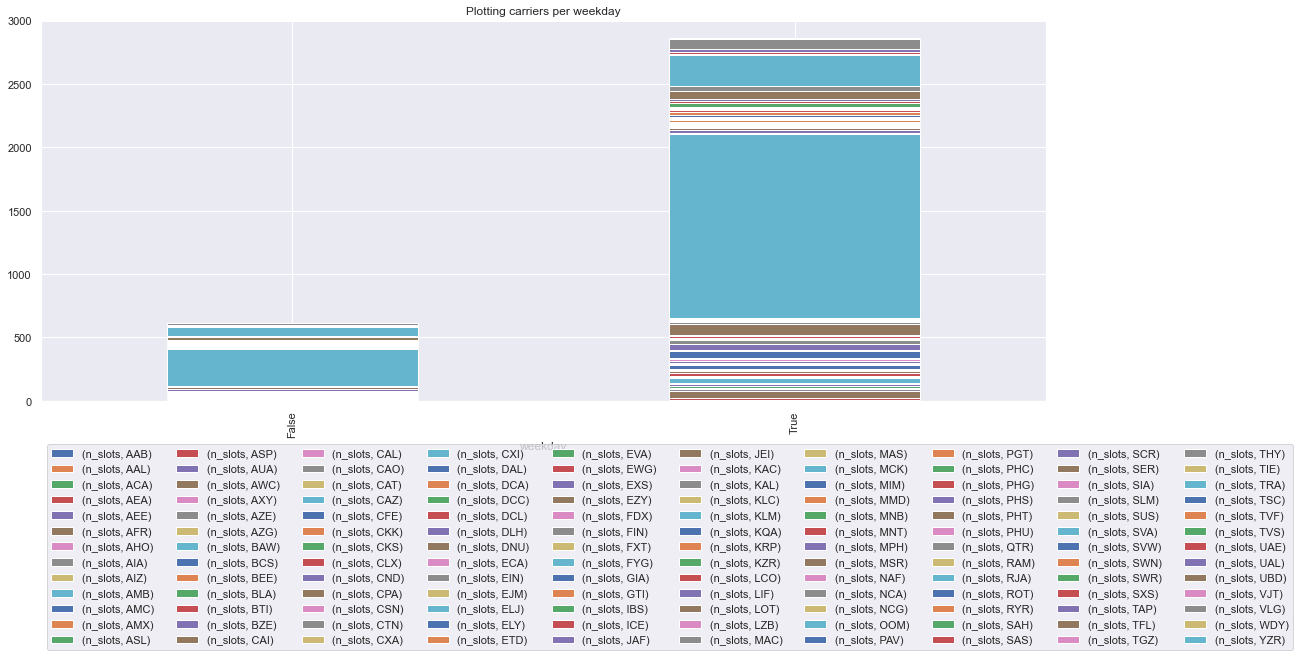

In [469]:
stack_per_timegroup(arrivals_df, 'weekday')

## Getting all the relevant indicators of the database

In [513]:
def get_indicators(df):
    total_slots = df.shape[0]
    
    def tot_hi_sh_di(df, timegroup):
        ''' Returns the
        1. total n of slots per timegroup 
        2. highest amount of slots per timegroup for an individual carrier
        3. share of slots for the carrier with the highest amount of slots
        4. percentage distribution of slots '''
        
        total = group_per_timegroup(df, timegroup).groupby(level=0).sum()
        highest = group_per_timegroup(df, timegroup).groupby(level=0).max()
        share = highest / total
        dist = total / df.shape[0]
        
        total = total.add_suffix('_total')  
        highest = highest.add_suffix('_highest')
        share = share.add_suffix('_share_of_highest')
        dist = dist.add_suffix('_dist')
        
        return pd.concat([total, highest, share, dist], axis=1)

    return {
            'day' : tot_hi_sh_di(df, 'day'),
            'hour' : tot_hi_sh_di(df, 'hour'),
            'daysection' : tot_hi_sh_di(df, 'daysection'),
            'weekday' : tot_hi_sh_di(df, 'weekday'),
        }

def get_means(indicators):
    ''' 
    Gets the means of an indicators list defined before.
    ToDo: Should all this go in a class? '''
    
    return {
            'day' : round(indicators['day']['n_slots_share_of_highest'].mean(), 3),
            'hour' : round(indicators['hour']['n_slots_share_of_highest'].mean(), 3),
            'daysection' : round(indicators['daysection']['n_slots_share_of_highest'].mean(), 3),
            'weekday' : round(indicators['weekday']['n_slots_share_of_highest'].mean(), 3)
        }

def plot_indicators(df):
    ax = sns.barplot(x = df.index, y = 'n_slots_share_of_highest', data=df, color= 'red')
    ax.set_title(f"Share of Top Carrier of all slots in timerange {df.index.name}")

Testcase below for individual airline

,n_slots_total,n_slots_highest,n_slots_share_of_highest,n_slots_dist
weekday,,,,
False,30,18,0.600000,0.06135
True,459,286,0.623094,0.93865


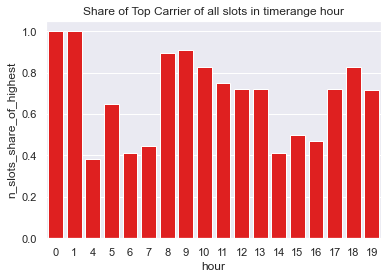

In [640]:
indicators = get_indicators(arrivals_df)
arrivals_df = airport_data['London City']
plot_indicators(indicators['hour'])
indicators['weekday']

In [642]:
# Getting top 5, top 10 and top 20 of carriers
carrier_df = arrivals_df.groupby('carrier').count()[['icao24']]\
                                           .sort_values(by='icao24', ascending=False)
top_1, top_5, top_10, top_20 = carrier_df.head(1), carrier_df[0:5], carrier_df[0:10], carrier_df[0:20]

# Select function for future use
def select_topx(df, topx):
    return df[df['carrier'].isin(topx.index.values)]

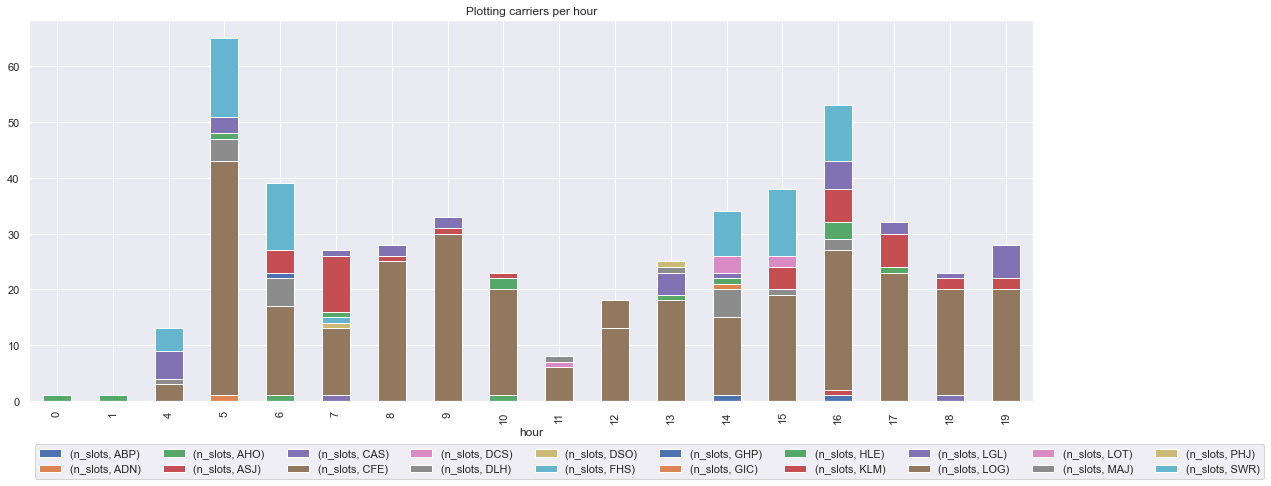

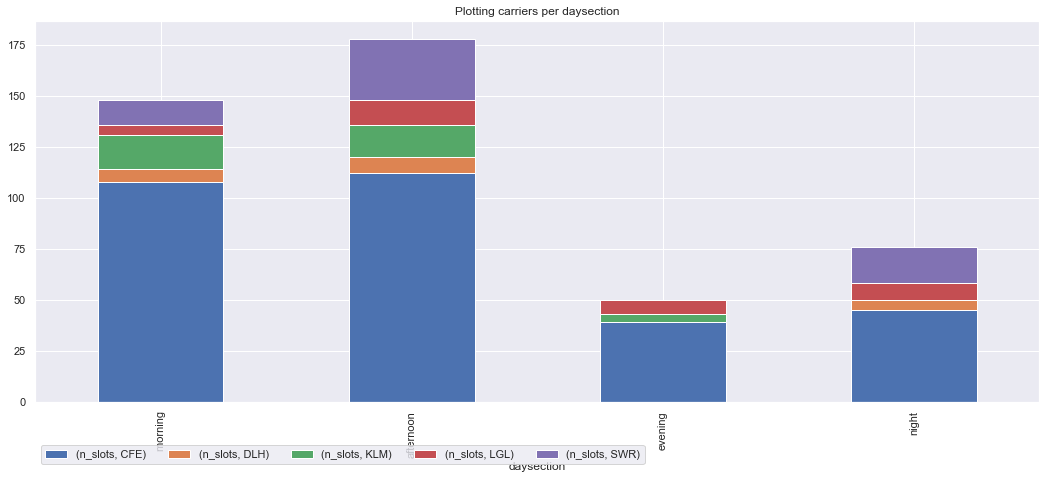

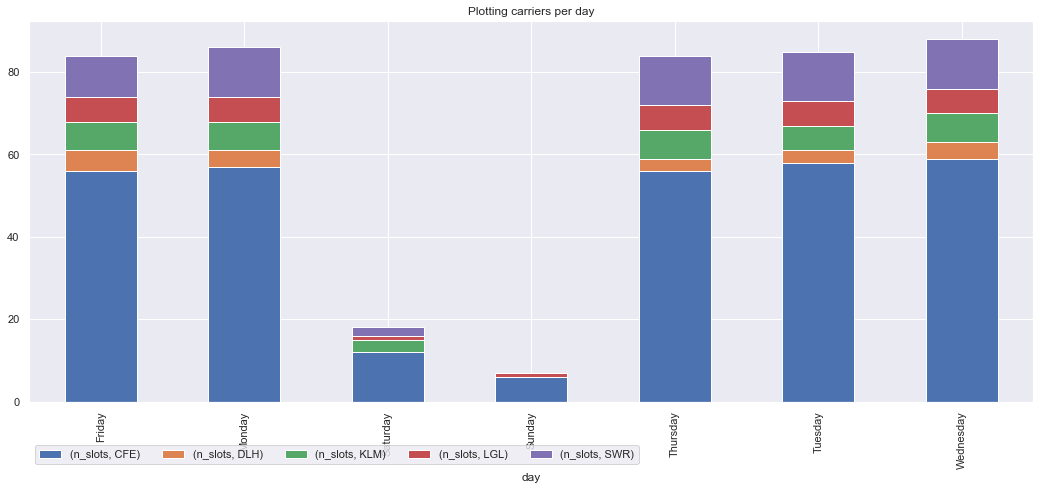

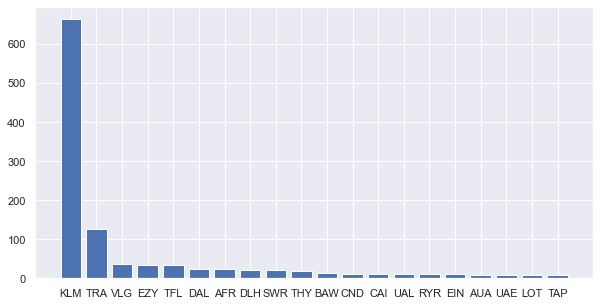

In [643]:
stack_per_timegroup(select_topx(arrivals_df, top_20), 'hour')
stack_per_timegroup(select_topx(arrivals_df, top_5), 'daysection')
stack_per_timegroup(select_topx(arrivals_df, top_5), 'day')

plt.figure(figsize=(10,5))
plt.bar(top_20_df.index, top_20_df['icao24'], data=top_20_df);

### Getting the relevant indicators of all the airlines

In [612]:
airport_indicators = {}
airport_means = {}
for name, airport in airport_data.items():
    airport_indicators[name] = get_indicators(airport)
    airport_means[name] = get_means(airport_indicators[name])
    print(f'getting indicators of airport {name}')

getting indicators of airport Singapore Changi
getting indicators of airport Seoul Incheon
getting indicators of airport Tokyo Haneda
getting indicators of airport Hong Kong
getting indicators of airport Doha Hamad
getting indicators of airport Munich
getting indicators of airport Centrair Nagoya
getting indicators of airport London Heathrow
getting indicators of airport Zurich
getting indicators of airport Frankfurt
getting indicators of airport Tokyo Narita
getting indicators of airport Amsterdam Schiphol
getting indicators of airport Kansai
getting indicators of airport Vancouver
getting indicators of airport Taiwan Taoyuan
getting indicators of airport Helsinki-Vantaa
getting indicators of airport Vienna
getting indicators of airport Copenhagen
getting indicators of airport Sydney
getting indicators of airport Cape Town
getting indicators of airport Brisbane
getting indicators of airport Dubai
getting indicators of airport Auckland
getting indicators of airport Hamburg
getting indi

<AxesSubplot:>

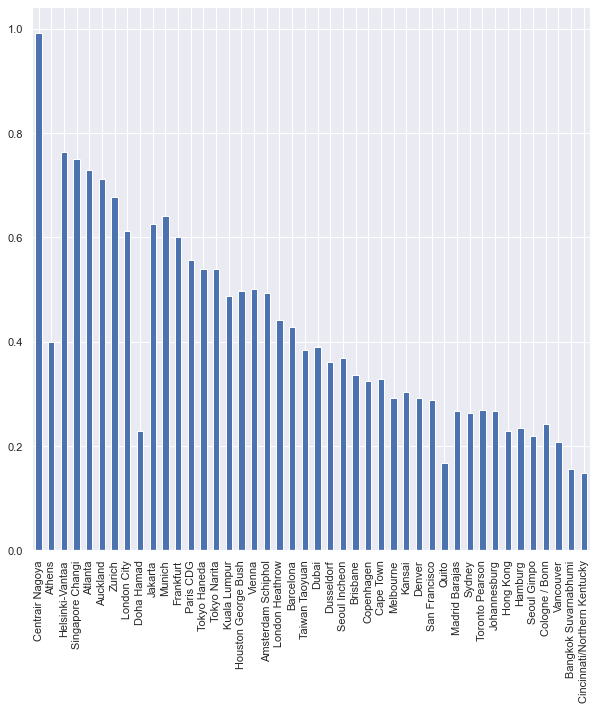

In [625]:
all_means = pd.DataFrame(airport_means).transpose().sort_values(by = 'day', ascending=False)
all_means['weekday'].plot(kind='bar', figsize=(10,10))


## Old leftover section

In the below I tried to analyze the amount of arrivals per hour per carrier, in order to see if there are any time slots in which one carrier is privileged above the other carriers. Clearly KLM is dominating all carriers in particular during the day. It has most competition between 17:00  and 23:00. Between 19:00 and 20.00 it has to concede in arrivals to Easy Jet and Transavia. This representation is not really good yet because there are many overlapping points.


In [466]:
def get_hourly_per_carrier(carrier):
    carrier_df = carriers_hours_df[carriers_hours_df['carrier']==carrier]
    return carrier_df.groupby('hours').count()['icao24'].to_frame()

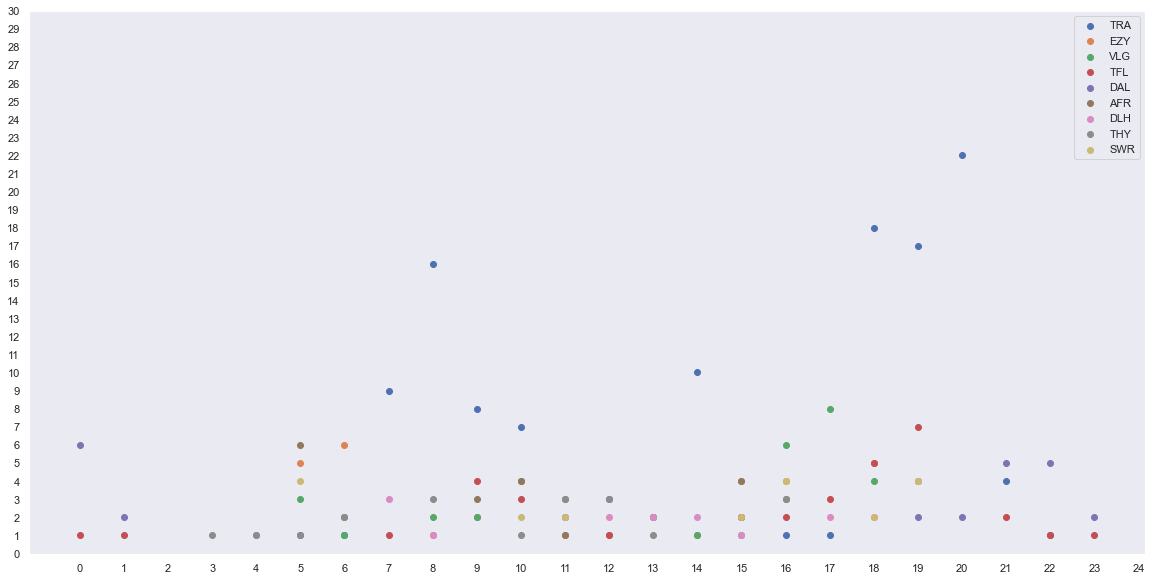

In [467]:
plt.figure(figsize = (20,10))

for carrier in carrier_df[1:10].index:
    carrier_h = get_hourly_per_carrier(carrier)
    plt.scatter(carrier_h.index, 'icao24', data=carrier_h, label=carrier)

plt.legend(ncol=len(carrier_h.columns))

xminor = np.arange(0, 25, 1)
yminor = np.arange(0, 31, 1)

plt.xticks(xminor)
plt.yticks(yminor)

plt.tick_params(grid_alpha=0.3, which='both')
plt.grid(which='both')

---
Top 10 Excluding KLM from the dataset gives some interesting insights. Most competition is between Transavia, and EASY Jet, although Delta Airlines (a SkyTeam alliance partner) seems to have control over some of the later slots (between 20:00 and 2:00). This plot needs to be improved as well. 